In [1]:
import csv
import cv2
import numpy as np

lines = []

with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [2]:
def process_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

In [3]:
car_images = []
steering_angles = []
for row in lines[1:]:
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.3 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    path = './data/' # fill in the path to your training IMG directory
    
    img_center = process_img(cv2.imread(path + row[0].replace(" ", "")))
    img_center_fliped = np.fliplr(img_center)
    img_left = process_img(cv2.imread(path + row[1].replace(" ", "")))
    img_left_fliped = np.fliplr(img_left)
    img_right = process_img(cv2.imread(path + row[2].replace(" ", "")))
    img_right_fliped = np.fliplr(img_right)

    # add images and angles to data set
    car_images.extend([img_center, img_left, img_right, img_center_fliped, img_left_fliped, img_right_fliped])
    steering_angles.extend([steering_center, steering_left, steering_right, -1.0 * steering_center, -1.0 * steering_left, -1.0 * steering_right])

In [4]:

lines = []

with open('./new_data_t1_2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
for row in lines[1:]:
    steering_center = float(row[3])

    # create adjusted steering measurements for the side camera images
    correction = 0.25 # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction

    # read in images from center, left and right cameras
    path = '' # fill in the path to your training IMG directory
    
    img_center = process_img(cv2.imread(path + row[0].replace(" ", "")))
    img_center_fliped = np.fliplr(img_center)
    img_left = process_img(cv2.imread(path + row[1].replace(" ", "")))
    img_left_fliped = np.fliplr(img_left)
    img_right = process_img(cv2.imread(path + row[2].replace(" ", "")))
    img_right_fliped = np.fliplr(img_right)

    # add images and angles to data set
    car_images.extend([img_center, img_left, img_right, img_center_fliped, img_left_fliped, img_right_fliped])
    steering_angles.extend([steering_center, steering_left, steering_right, -1.0 * steering_center, -1.0 * steering_left, -1.0 * steering_right])

In [5]:
from sklearn.model_selection import train_test_split
X_train = np.array(car_images)
del car_images
y_train = np.array(steering_angles)
del steering_angles
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2333)

In [6]:
import keras
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.activations import *

image_shape = X_train[0].shape

model = Sequential()
model.add(Lambda(lambda x: x / 225.0 - 0.5, input_shape=image_shape))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(3,160,320)))

model.add(Conv2D(24, (5,5), strides=(2,2), activation=None, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(32, (5,5), strides=(2,2), activation=None, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))

#model.add(Conv2D(32, (5,5), strides=(2,2), activation=None, padding='valid'))
#model.add(BatchNormalization())
#model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(48, (3,3), strides=(1,1), activation=None, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))

model.add(Conv2D(48, (3,3), strides=(1,1), activation=None, padding='valid'))
model.add(BatchNormalization())
model.add(Activation('elu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(64,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', lr=0.0001)

Using TensorFlow backend.


In [7]:
import matplotlib.pyplot as plt
#from keras.utils.vis_utils import plot_model
#from IPython.display import Image
#plt.rcParams['figure.figsize'] = (3, 1)
#plot_model(model, to_file='model.png', show_shapes=True)
#Image(filename = 'model.png')

In [8]:
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
#model = load_model('model.h5')

filepath="./models/t1/weights-improvement-{epoch:02d}-{val_loss:.2f}.f5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history_object = model.fit(X_train,
                           y_train,
                           batch_size=128,
                           validation_split=0.2,
                           epochs=15,
                           shuffle=True,
                           callbacks=callbacks_list)

/home/meirtz/anaconda3/envs/dl_dev/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 64521 samples, validate on 16131 samples
Epoch 1/15
64521/64521 [==============================] - 86s - loss: 3.4213 - val_loss: 0.8200
Epoch 2/15
64521/64521 [==============================] - 88s - loss: 0.5148 - val_loss: 0.3331
Epoch 3/15
64521/64521 [==============================] - 87s - loss: 0.2391 - val_loss: 0.1697
Epoch 4/15
64521/64521 [==============================] - 85s - loss: 0.1301 - val_loss: 0.0966
Epoch 5/15
64521/64521 [==============================] - 87s - loss: 0.0814 - val_loss: 0.0670
Epoch 6/15
64521/64521 [==============================] - 86s - loss: 0.0582 - val_loss: 0.0529
Epoch 7/15
64521/64521 [==============================] - 87s - loss: 0.0470 - val_loss: 0.0421
Epoch 8/15
64521/64521 [==============================] - 86s - loss: 0.0402 - val_loss: 0.0424
Epoch 9/15
64521/64521 [==============================] - 87s - loss: 0.0374 - val_loss: 0.0372
Epoch 10/15
64521/64521 [==============================] - 87s - loss: 0.0365 - val_lo

dict_keys(['val_loss', 'loss'])


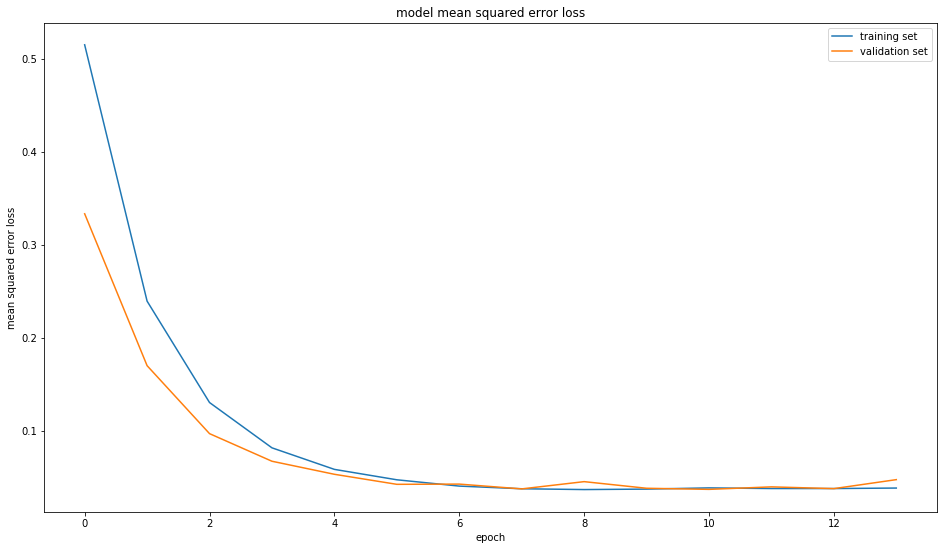

In [9]:
print(history_object.history.keys())
plt.rcParams['figure.figsize'] = (16, 9)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'][1:])
plt.plot(history_object.history['val_loss'][1:])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [10]:
model.save('./models/t1/final_model.h5')